# XGBoost Model for Time Series Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection # Make sure to import this
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [2]:
color_pal = sns.color_palette("rocket") #flare
plt.style.use('dark_background')

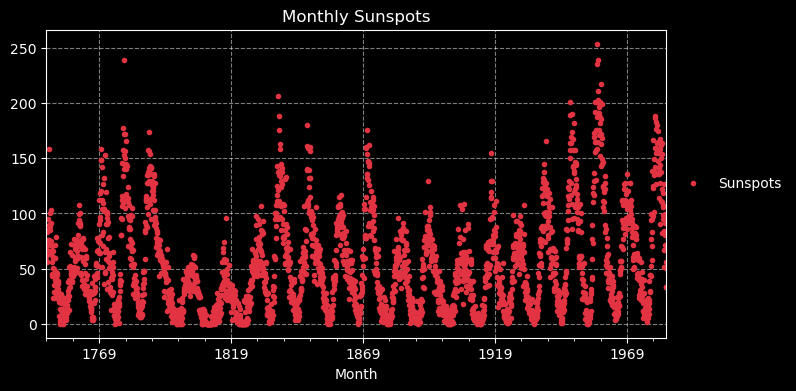

In [3]:
df = pd.read_csv('monthly-sunspots.csv')
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index(df['Month'])
del df['Month']

df.plot(style='.',
        figsize=(8,4),
        color=color_pal[3],
        title='Monthly Sunspots')

plt.grid(True, color='white', linestyle='--', alpha=0.5)

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    labelcolor='white')

plt.savefig('Sunspots_1.jpg', dpi=300, bbox_inches='tight')

plt.show()

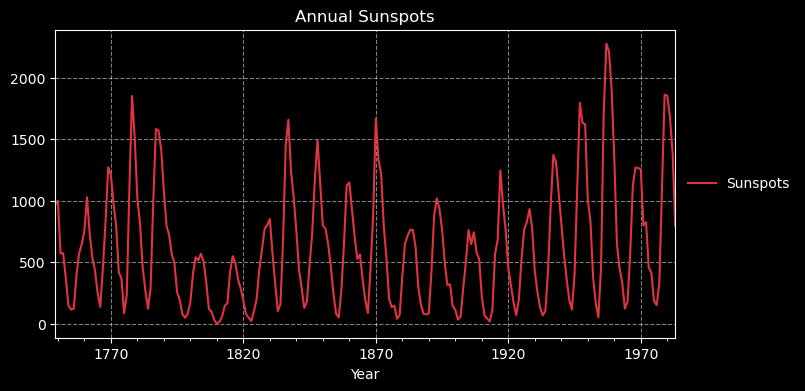

In [4]:
# From monthly to annual data
df = df.resample('YE').sum()
df = df.rename_axis('Year')

df.plot(style='-',
        figsize=(8,4),
        color=color_pal[3],
        title='Annual Sunspots')

plt.grid(True, color='white', linestyle='--', alpha=0.5)

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    labelcolor='white')

plt.savefig('Sunspots_2.jpg', dpi=300, bbox_inches='tight')

plt.show()

## Train / Test Split

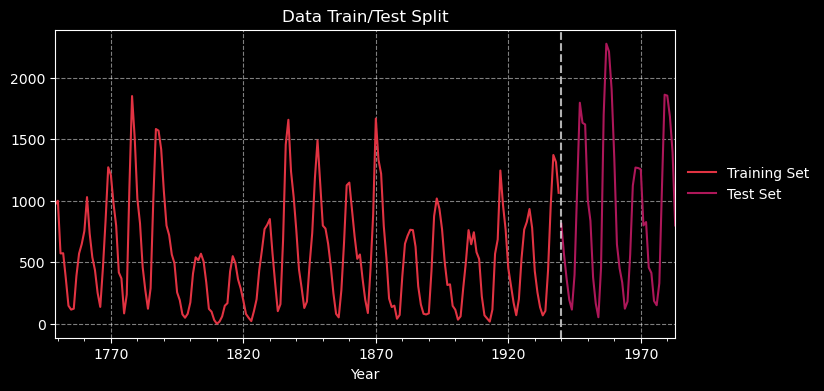

In [5]:
year_split = '1940'
train = df.loc[df.index < year_split]
test = df.loc[df.index >= year_split]

fig, ax = plt.subplots(figsize=(8,4))

train.plot(ax=ax, color=color_pal[3], label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, color=color_pal[2], label='Test Set')

ax.axvline(year_split, color='white', ls='--', alpha=0.7)

ax.legend(['Training Set', 'Test Set'], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, labelcolor='white')

plt.grid(True, color='white', linestyle='--', alpha=0.5)

plt.savefig('Sunspots_3.jpg', dpi=300, bbox_inches='tight')

plt.show()

## Time Series Cross Validation

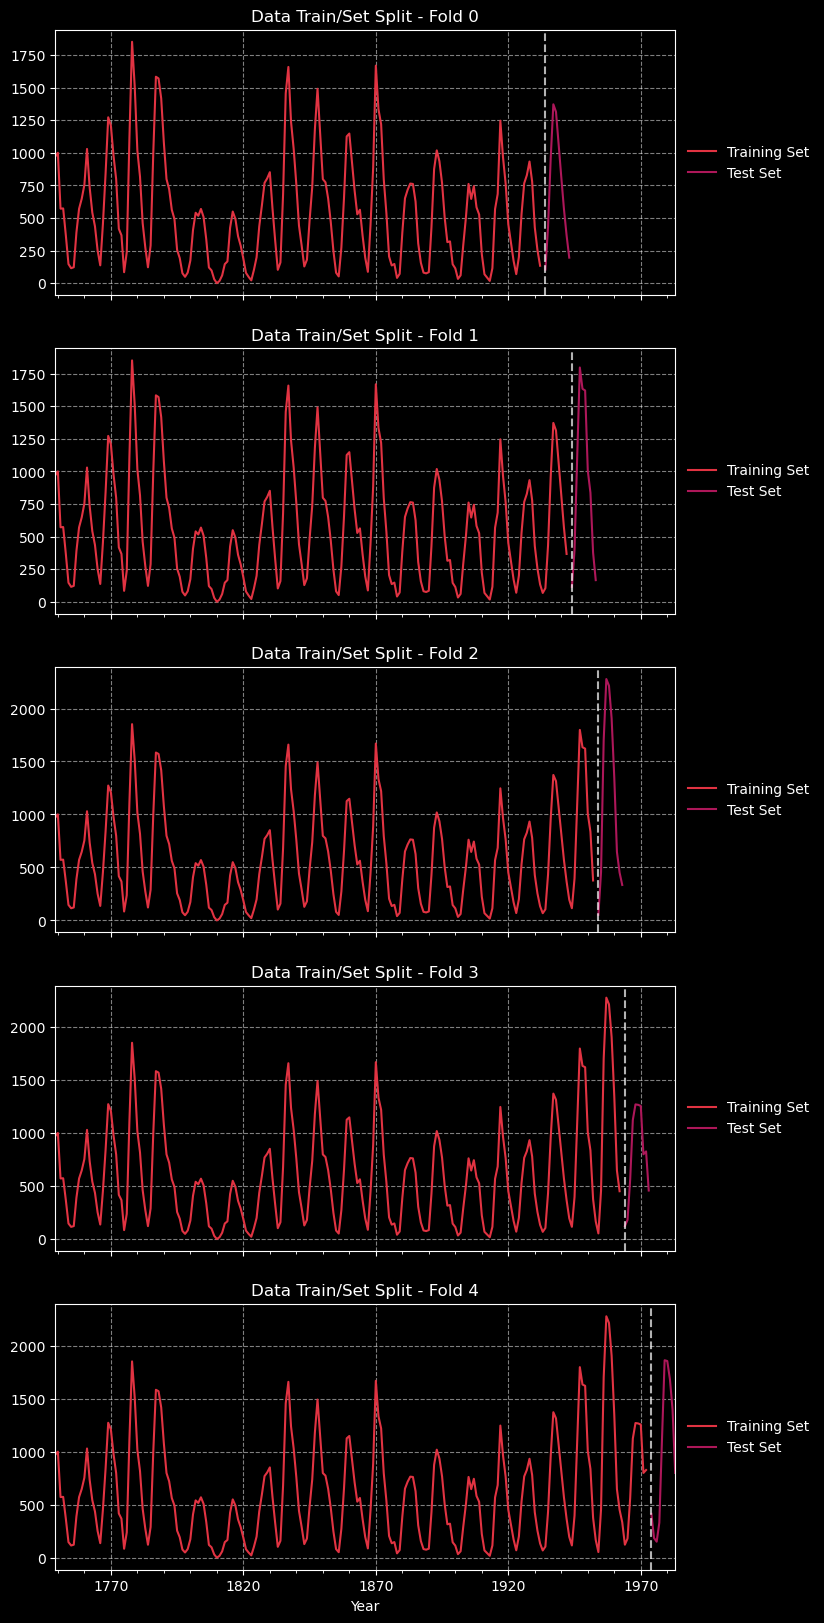

In [6]:
n_splits = 5
tss = TimeSeriesSplit(n_splits=n_splits, test_size=10, gap=1)
df = df.sort_index()


# Plot graphs
fig, axs = plt.subplots(n_splits, 1, figsize=(8,4*n_splits), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train['Sunspots'].plot(ax=axs[fold],
                           color=color_pal[3],
                           label='Training Set',
                           title=f'Data Train/Set Split - Fold {fold}')
    
    test['Sunspots'].plot(ax=axs[fold],
                          color=color_pal[2],
                          label='Test Set')
    
    axs[fold].axvline(test.index.min(), color='white', ls='--', alpha=0.7)

    axs[fold].grid(True, color='white', linestyle='--', alpha=0.5)

    axs[fold].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, labelcolor='white')
    
    fold += 1

plt.savefig('Sunspots_4.jpg', dpi=300, bbox_inches='tight')    

plt.show()

## Find seasonality

Strongest seasonal candidate: lag 10


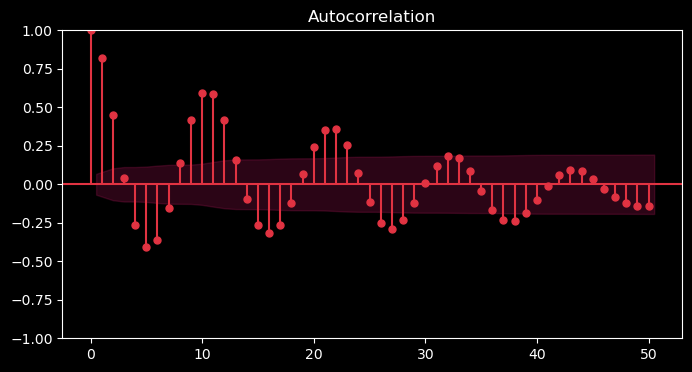

In [7]:
start_lag = 5
end_lag = 50

acf_vals = acf(df['Sunspots'], nlags=end_lag)
lag = np.argmax(acf_vals[start_lag:]) + start_lag
print(f'Strongest seasonal candidate: lag {lag}')

fig, ax = plt.subplots(figsize=(8, 4))
#plot_acf(df['Sunspots'], color=color_pal[2], lags=end_lag, ax=ax)

plot_acf(
    df['Sunspots'],
    lags=end_lag,
    ax=ax,
    color=color_pal[3],
    alpha=0.3,
    vlines_kwargs={'color': color_pal[3]})

for item in ax.collections:
    if isinstance(item, PolyCollection):
        item.set_color(color_pal[2])

plt.savefig('Sunspots_5.jpg', dpi=300, bbox_inches='tight')    

plt.show()

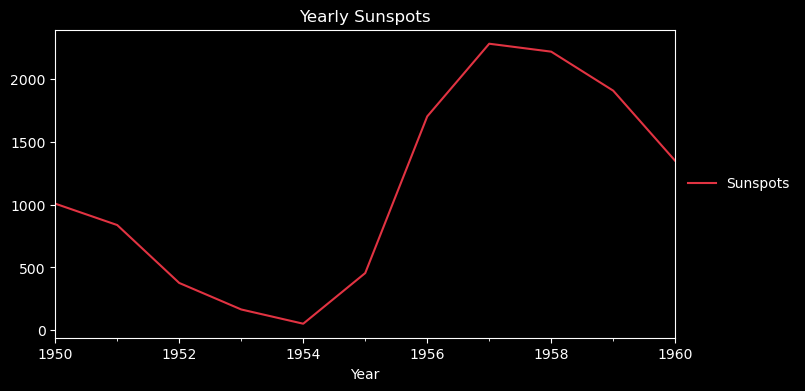

In [8]:
seasonality = 11 # we use the lag found previously
year_start = '1950'
year_end = str(int(year_start) + seasonality)

df.loc[(df.index > year_start) & (df.index < year_end)].plot(
    style='-',
    figsize=(8,4),
    color=color_pal[3],
    title='Yearly Sunspots')

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    labelcolor='white')

plt.savefig('Sunspots_6.jpg', dpi=300, bbox_inches='tight')

plt.show()

In [9]:
df_s = df.copy()

date_cutoff = '1778-01-01'
df_s = df_s.loc[df_s.index >= date_cutoff]

seasonality = 11

def create_feature(df_s):
    
    df_s['year'] = df_s.index.year
    
    # Seasonality
    df_s['years_since_start'] = df_s.index.year - df_s.index.year.min()
    df_s['seasonality_cycle'] = (df_s.index.year - df_s.index.year.min()) % seasonality

    return df_s

df_s = create_feature(df_s)

df_s

,Sunspots,year,years_since_start,seasonality_cycle
Year,,,,
1778-12-31,1852.4,1778,0,0
1779-12-31,1511.1,1779,1,1
1780-12-31,1017.6,1780,2,2
1781-12-31,817.1,1781,3,3
1782-12-31,461.5,1782,4,4
...,...,...,...,...
1979-12-31,1863.3,1979,201,3
1980-12-31,1855.8,1980,202,4
1981-12-31,1684.5,1981,203,5


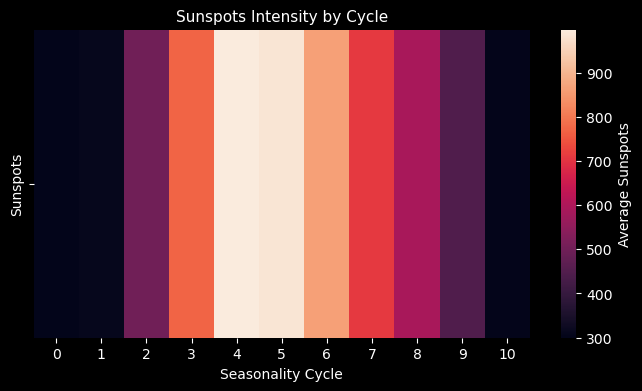

In [34]:
fig, ax = plt.subplots(figsize=(8,4))

avg = df_s.groupby('seasonality_cycle')['Sunspots'].mean()

sns.heatmap(
    avg.to_frame().T,
    cmap='rocket', 
    cbar_kws={'label': 'Average Sunspots'},
    ax=ax
)

ax.set_title('Sunspots Intensity by Cycle', fontsize=11)
ax.set_xlabel('Seasonality Cycle')
ax.set_ylabel('')

plt.savefig('Sunspots_7.jpg', dpi=300, bbox_inches='tight')

plt.show()

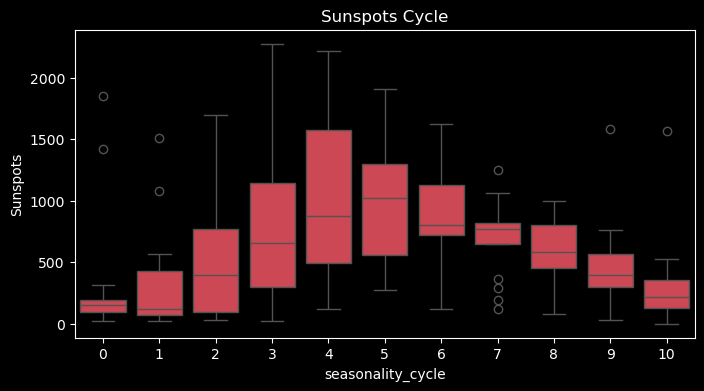

In [11]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(color=color_pal[3], data=df_s, x='seasonality_cycle', y='Sunspots')
ax.set_title('Sunspots Cycle')

plt.savefig('Sunspots_8.jpg', dpi=300, bbox_inches='tight')

plt.show()

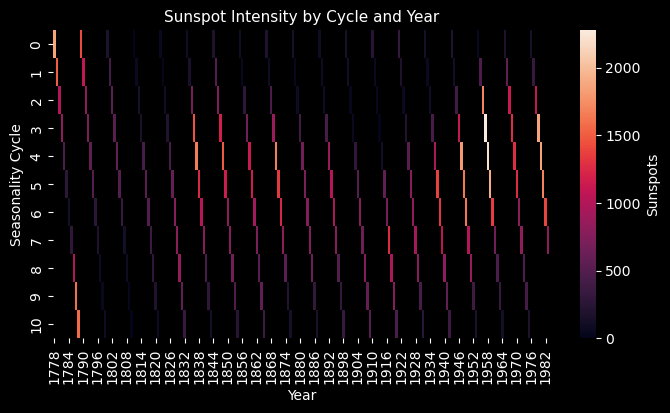

In [12]:
# There is a seasonality within the seasonality (second periodicity)

df_cycle = df_s.groupby(['seasonality_cycle', 'year'])['Sunspots'].mean().reset_index()
heatmap_data = df_cycle.pivot(index='seasonality_cycle', columns='year', values='Sunspots')

plt.figure(figsize=(8, 4))

sns.heatmap(heatmap_data, cmap='rocket', cbar_kws={'label': 'Sunspots'})

plt.title('Sunspot Intensity by Cycle and Year', fontsize=11)
plt.xlabel('Year')
plt.ylabel('Seasonality Cycle')

plt.savefig('Sunspots_9.jpg', dpi=300, bbox_inches='tight')

plt.show()

In [53]:
df_s2 = df.copy()

date_cutoff_2 = '1800-01-01'
df_s2 = df_s2.loc[df_s2.index >= date_cutoff_2]

seasonality_1 = 11
seasonality_2 = 100

min_year = df_s2.index.year.min()

df_s2['years_since_start'] = df_s2.index.year - min_year

df_s2['cycle_11_year'] = df_s2['years_since_start'] % seasonality_1

df_s2['cycle_100_year'] = df_s2['years_since_start'] % seasonality_2

df_dual_cycle = df_s2.groupby(['cycle_11_year', 'cycle_100_year'])['Sunspots'].mean().reset_index()

heatmap_data_2 = df_dual_cycle.pivot(index='cycle_11_year', columns='cycle_100_year', values='Sunspots')

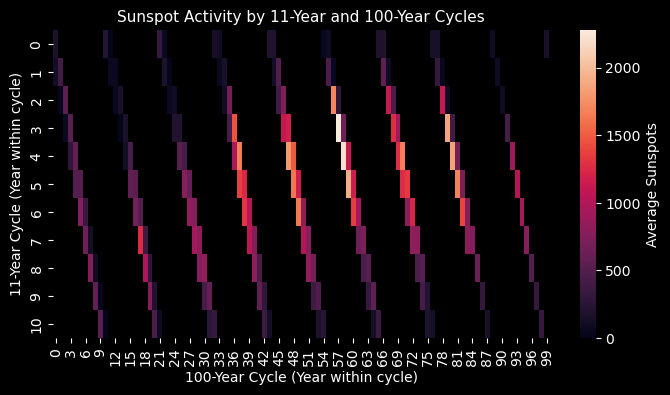

In [54]:
plt.figure(figsize=(8, 4))

sns.heatmap(
    heatmap_data_2,
    cmap='rocket',
    cbar_kws={'label': 'Average Sunspots'}
)

plt.title('Sunspot Activity by 11-Year and 100-Year Cycles', fontsize=11)

plt.xlabel('100-Year Cycle (Year within cycle)')
plt.ylabel('11-Year Cycle (Year within cycle)')

#plt.savefig('Sunspots_10.jpg', dpi=300, bbox_inches='tight')

plt.show()

## Feature Creation

In [15]:
def create_feature(df):

    df = df.copy()
    
    df['year'] = df.index.year
    
    # Seasonality
    df['years_since_start'] = df.index.year - df.index.year.min()
    df['seasonality_cycle'] = (df.index.year - df.index.year.min()) % seasonality

    return df

df = create_feature(df)

In [16]:
def add_lags(df):
    target_map = df['Sunspots'].to_dict()

    df['lag5'] = (df.index - pd.DateOffset(years=5)).map(target_map)
    df['lag10'] = (df.index - pd.DateOffset(years=10)).map(target_map)
    df['lag15'] = (df.index - pd.DateOffset(years=15)).map(target_map)
    df['lag20'] = (df.index - pd.DateOffset(years=20)).map(target_map)
    
    return df

df = add_lags(df)

In [17]:
def add_long_term_features(df):
    df = df.copy()

    n = 10 #forecast period
    for window in [5, 10, 20]:
        df[f'rolling_mean_{window}'] = df['Sunspots'].shift(n).rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['Sunspots'].shift(n).rolling(window=window).std()
        df[f'rolling_max_{window}'] = df['Sunspots'].shift(n).rolling(window=window).max()
        df[f'rolling_min_{window}'] = df['Sunspots'].shift(n).rolling(window=window).min()

    return df

df = add_long_term_features(df)

In [18]:
df = df.dropna()
df.head()

,Sunspots,year,years_since_start,seasonality_cycle,lag5,lag10,lag15,lag20,rolling_mean_5,rolling_std_5,rolling_max_5,rolling_min_5,rolling_mean_10,rolling_std_10,rolling_max_10,rolling_min_10,rolling_mean_20,rolling_std_20,rolling_max_20,rolling_min_20
Year,,,,,,,,,,,,,,,,,,,,
1778-12-31,1852.4,1778,29,7,417.3,838.1,541.4,571.2,423.20,266.884095,838.1,136.9,582.33,272.959110,1030.2,136.9,532.645,294.769468,1030.2,114.8
1779-12-31,1511.1,1779,30,8,367.4,1273.1,436.2,647.6,590.58,465.561266,1273.1,136.9,644.88,350.291637,1273.1,136.9,547.745,324.634399,1273.1,114.8
1780-12-31,1017.6,1780,31,9,84.1,1209.6,250.9,754.3,782.32,487.588784,1273.1,136.9,690.41,393.071129,1273.1,136.9,558.190,342.826043,1273.1,114.8
1781-12-31,817.1,1781,32,10,237.8,979.0,136.9,1030.2,950.74,328.352270,1273.1,453.9,685.29,388.459780,1273.1,136.9,578.545,355.533016,1273.1,114.8
1782-12-31,461.5,1782,33,0,1110.0,797.9,453.9,733.8,1019.54,214.536554,1273.1,797.9,691.70,389.875467,1273.1,136.9,589.760,358.890647,1273.1,114.8


## Visualize Feature/Target Relationship

## Create the Model

In [19]:
df.columns

Index(['Sunspots', 'year', 'years_since_start', 'seasonality_cycle', 'lag5',
       'lag10', 'lag15', 'lag20', 'rolling_mean_5', 'rolling_std_5',
       'rolling_max_5', 'rolling_min_5', 'rolling_mean_10', 'rolling_std_10',
       'rolling_max_10', 'rolling_min_10', 'rolling_mean_20', 'rolling_std_20',
       'rolling_max_20', 'rolling_min_20'],
      dtype='object')

In [20]:
n_splits = 5
tss = TimeSeriesSplit(n_splits=n_splits, test_size=10, gap=1)
df = df.sort_index()

fold = 0
preds = []
scores = []

all_preds_df = []

for train_idx, val_idx in tss.split(df):
    print(f"Fold: {fold}")
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['year', 'years_since_start', 'seasonality_cycle', 'lag5',
       'lag10', 'lag15', 'lag20', 'rolling_mean_5', 'rolling_std_5',
       'rolling_max_5', 'rolling_min_5', 'rolling_mean_10', 'rolling_std_10',
       'rolling_max_10', 'rolling_min_10', 'rolling_mean_20', 'rolling_std_20',
       'rolling_max_20', 'rolling_min_20']
    TARGET = 'Sunspots'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=200000,
                           early_stopping_rounds=1000,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.0001)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=10000)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    # Store the predictions in a temporary DataFrame with the correct index
    temp_df = pd.DataFrame(y_pred, index=X_test.index, columns=['prediction'])
    all_preds_df.append(temp_df)

    fold += 1
    print("")

print(f"Mean RMSE: {np.mean(scores)}")

# Combine all the predictions into a single DataFrame
combined_preds = pd.concat(all_preds_df)

# Merge the combined predictions with the original dataframe
df = df.merge(combined_preds, how='left', left_index=True, right_index=True)

Fold: 0
[0]	validation_0-rmse:676.14640	validation_1-rmse:837.37625
[10000]	validation_0-rmse:332.93889	validation_1-rmse:492.57464
[20000]	validation_0-rmse:203.95020	validation_1-rmse:378.02556
[30000]	validation_0-rmse:148.88193	validation_1-rmse:336.09755
[40000]	validation_0-rmse:122.76445	validation_1-rmse:317.36593
[46539]	validation_0-rmse:110.16040	validation_1-rmse:311.62708

Fold: 1
[0]	validation_0-rmse:686.84564	validation_1-rmse:1086.77356
[10000]	validation_0-rmse:337.56599	validation_1-rmse:725.67934
[20000]	validation_0-rmse:208.04686	validation_1-rmse:594.76832
[30000]	validation_0-rmse:153.39383	validation_1-rmse:538.56826
[40000]	validation_0-rmse:127.53848	validation_1-rmse:486.18193
[50000]	validation_0-rmse:110.14617	validation_1-rmse:461.10338
[60000]	validation_0-rmse:96.94546	validation_1-rmse:455.50961
[70000]	validation_0-rmse:84.92068	validation_1-rmse:452.97520
[80000]	validation_0-rmse:74.43958	validation_1-rmse:451.90023
[90000]	validation_0-rmse:65.7210

## Feature Importance

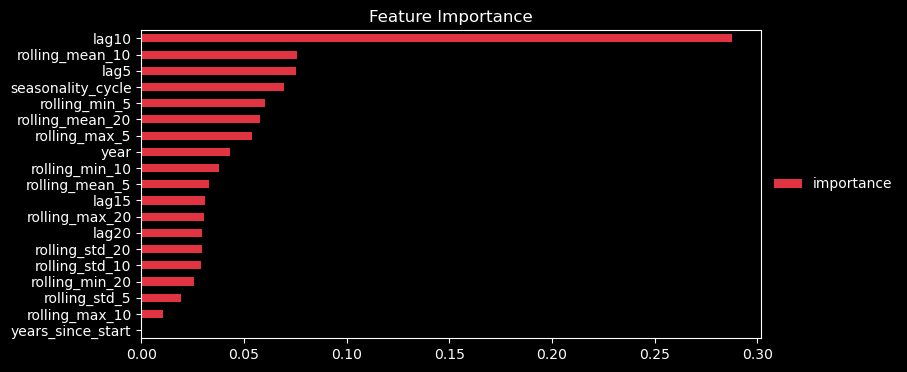

In [21]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])

fi.sort_values('importance').plot(kind='barh',
                                  figsize=(8,4),
                                  color=color_pal[3],
                                  title='Feature Importance')

plt.legend(loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    labelcolor='white')

plt.savefig('Sunspots_11.jpg', dpi=300, bbox_inches='tight')

plt.show()

## Forecast on Test

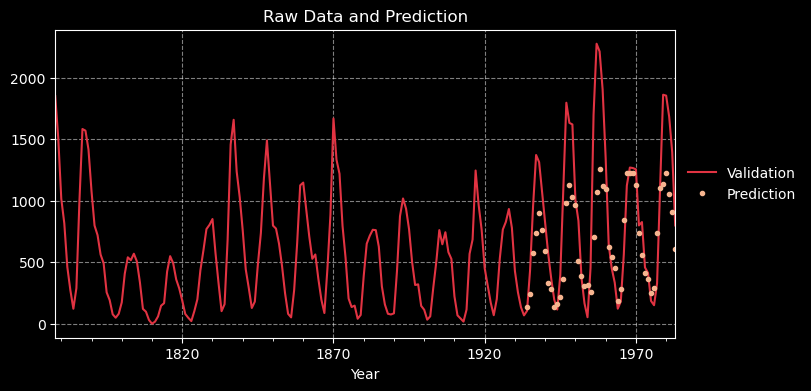

In [22]:
ax = df[['Sunspots']].plot(figsize=(8,4), color=color_pal[3])

df['prediction'].plot(ax=ax, style='.', color=color_pal[5])

plt.legend(
    ['Validation', 'Prediction'],
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    labelcolor='white')

plt.grid(True, color='white', linestyle='--', alpha=0.5)

ax.set_title('Raw Data and Prediction')

plt.savefig('Sunspots_12.jpg', dpi=300, bbox_inches='tight')

plt.show()

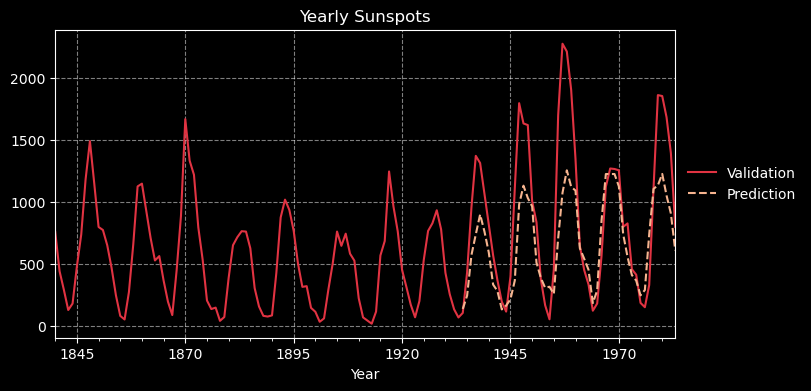

In [23]:
ax = df.loc[(df.index >= '1840') & (df.index < '1984')]['Sunspots'] \
    .plot(figsize=(8,4), title='Yearly Sunspots', color=color_pal[3])

df.loc[(df.index >= '1840') & (df.index < '1984')]['prediction'] \
    .plot(style='--', color=color_pal[5])

plt.legend(
    ['Validation', 'Prediction'],
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    labelcolor='white')

plt.grid(True, color='white', linestyle='--', alpha=0.5)

plt.savefig('Sunspots_13.jpg', dpi=300, bbox_inches='tight')

plt.show()

## Predicting the Future

• Retraining on all data. \
• Creating an empy dataframe for future date ranges. \
• Run those dates trhough the feature creation code.

In [24]:
FEATURES = ['year', 'years_since_start', 'seasonality_cycle', 'lag5',
       'lag10', 'lag15', 'lag20', 'rolling_mean_5', 'rolling_std_5',
       'rolling_max_5', 'rolling_min_5', 'rolling_mean_10', 'rolling_std_10',
       'rolling_max_10', 'rolling_min_10', 'rolling_mean_20', 'rolling_std_20',
       'rolling_max_20', 'rolling_min_20']
TARGET = 'Sunspots'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=200000,
                       early_stopping_rounds=1000,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.0001)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=10000)

[0]	validation_0-rmse:797.14430
[10000]	validation_0-rmse:387.92035
[20000]	validation_0-rmse:245.19240
[30000]	validation_0-rmse:186.61885
[40000]	validation_0-rmse:157.23421
[50000]	validation_0-rmse:136.25579
[60000]	validation_0-rmse:118.67304
[70000]	validation_0-rmse:103.98578
[80000]	validation_0-rmse:93.44995
[90000]	validation_0-rmse:86.58424
[100000]	validation_0-rmse:79.14786
[110000]	validation_0-rmse:71.51944
[120000]	validation_0-rmse:65.89352
[130000]	validation_0-rmse:60.70153
[140000]	validation_0-rmse:56.05636
[150000]	validation_0-rmse:51.56017
[160000]	validation_0-rmse:46.75200
[170000]	validation_0-rmse:42.91290
[180000]	validation_0-rmse:39.36993
[190000]	validation_0-rmse:36.10045
[199999]	validation_0-rmse:33.39544


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=1000,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0001, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None,
             n_estimators=200000, n_jobs=None, num_parallel_tree=None, ...)

In [25]:
df.index.max()

Timestamp('1983-12-31 00:00:00')

In [26]:
# Creating the future dataframe
future = pd.date_range('1984-12-31', periods=10, freq='YE')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future

,Sunspots,year,years_since_start,seasonality_cycle,lag5,lag10,lag15,lag20,rolling_mean_5,rolling_std_5,...,rolling_mean_10,rolling_std_10,rolling_max_10,rolling_min_10,rolling_mean_20,rolling_std_20,rolling_max_20,rolling_min_20,prediction,isFuture
1778-12-31,1852.4,1778.0,29.0,7.0,417.3,838.1,541.4,571.2,423.20,266.884095,...,582.33,272.959110,1030.2,136.9,532.645,294.769468,1030.2,114.8,NaN,False
1779-12-31,1511.1,1779.0,30.0,8.0,367.4,1273.1,436.2,647.6,590.58,465.561266,...,644.88,350.291637,1273.1,136.9,547.745,324.634399,1273.1,114.8,NaN,False
1780-12-31,1017.6,1780.0,31.0,9.0,84.1,1209.6,250.9,754.3,782.32,487.588784,...,690.41,393.071129,1273.1,136.9,558.190,342.826043,1273.1,114.8,NaN,False
1781-12-31,817.1,1781.0,32.0,10.0,237.8,979.0,136.9,1030.2,950.74,328.352270,...,685.29,388.459780,1273.1,136.9,578.545,355.533016,1273.1,114.8,NaN,False
1782-12-31,461.5,1782.0,33.0,0.0,1110.0,797.9,453.9,733.8,1019.54,214.536554,...,691.70,389.875467,1273.1,136.9,589.760,358.890647,1273.1,114.8,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1990-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1991-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1992-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [27]:
df_and_future = create_feature(df_and_future)
df_and_future = add_lags(df_and_future)
df_and_future = add_long_term_features(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()
future_w_features

,Sunspots,year,years_since_start,seasonality_cycle,lag5,lag10,lag15,lag20,rolling_mean_5,rolling_std_5,...,rolling_mean_10,rolling_std_10,rolling_max_10,rolling_min_10,rolling_mean_20,rolling_std_20,rolling_max_20,rolling_min_20,prediction,isFuture
1984-12-31,NaN,1984,206,8,1863.3,412.9,1266.7,122.4,750.80,340.511975,...,815.86,402.445793,1270.7,180.7,980.760,659.555986,2278.2,122.4,NaN,True
1985-12-31,NaN,1985,207,9,1855.8,185.5,1256.3,180.7,536.64,273.178024,...,816.34,401.606046,1270.7,185.5,967.265,673.485080,2278.2,122.4,NaN,True
1986-12-31,NaN,1986,208,10,1684.5,150.6,799.8,562.5,406.80,271.102610,...,775.15,448.874591,1270.7,150.6,889.770,673.844413,2278.2,122.4,NaN,True
1987-12-31,NaN,1987,209,0,1395.5,329.8,827.2,1124.0,307.32,135.736867,...,695.73,450.550345,1270.7,150.6,792.350,599.265997,2215.1,122.4,NaN,True
1988-12-31,NaN,1988,210,1,799.6,1111.9,457.8,1270.7,438.14,391.418373,...,679.85,430.380419,1266.7,150.6,737.190,504.731148,1905.0,122.4,NaN,True
1989-12-31,NaN,1989,211,2,NaN,1863.3,412.9,1266.7,728.22,745.410174,...,739.51,546.464756,1863.3,150.6,735.105,499.714323,1863.3,122.4,NaN,True
1990-12-31,NaN,1990,212,3,NaN,1855.8,185.5,1256.3,1062.28,812.627920,...,799.46,635.146965,1863.3,150.6,760.530,543.517764,1863.3,122.4,NaN,True
1991-12-31,NaN,1991,213,4,NaN,1684.5,150.6,799.8,1369.06,657.054795,...,887.93,694.080629,1863.3,150.6,812.415,580.370328,1863.3,122.4,NaN,True
1992-12-31,NaN,1992,214,5,NaN,1395.5,329.8,827.2,1582.20,324.182988,...,944.76,711.600228,1863.3,150.6,859.630,587.801047,1863.3,122.4,NaN,True
1993-12-31,NaN,1993,215,6,NaN,799.6,1111.9,457.8,1519.74,445.014846,...,978.94,693.592309,1863.3,150.6,882.875,575.002830,1863.3,122.4,NaN,True


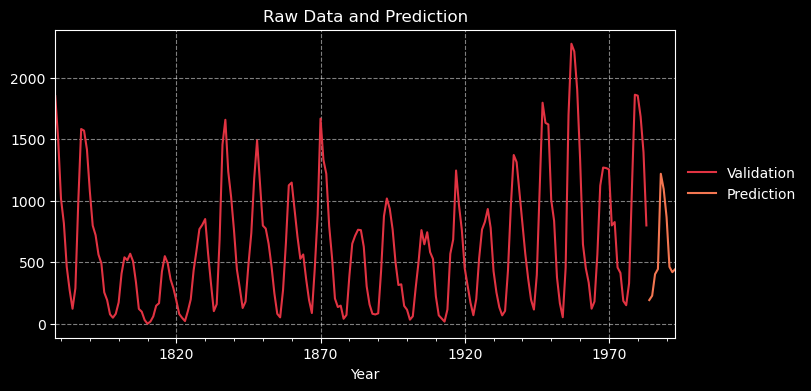

In [30]:
# Predict the future
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

ax = df[['Sunspots']].plot(figsize=(8,4), color=color_pal[3])
future_w_features['pred'].plot(ax=ax, style='-', color=color_pal[4])

plt.legend(
    ['Validation', 'Prediction'],
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    labelcolor='white')

plt.grid(True, color='white', linestyle='--', alpha=0.5)

ax.set_title('Raw Data and Prediction')

plt.savefig('Sunspots_14.jpg', dpi=300, bbox_inches='tight')

plt.show()

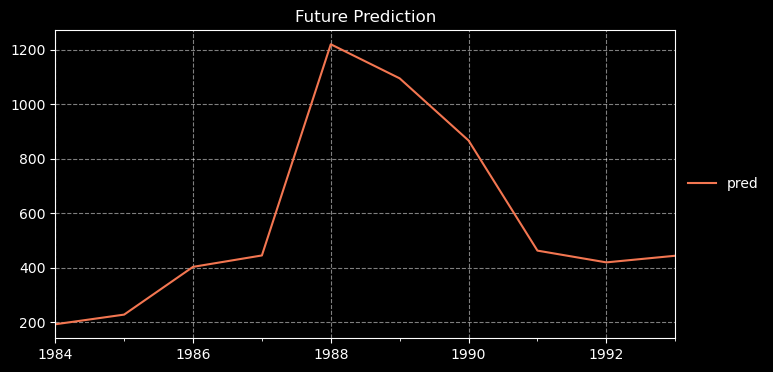

In [31]:
future_w_features['pred'].plot(figsize=(8,4),
                               title='Future Prediction',
                               color=color_pal[4])

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    labelcolor='white')

plt.grid(True, color='white', linestyle='--', alpha=0.5)

plt.savefig('Sunspots_15.jpg', dpi=300, bbox_inches='tight')

plt.show()

## Saving the Model

In [33]:
# Saving the model
reg.save_model('model_V9.json')